In [2]:
import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
from heapq import nsmallest
from scipy.signal import butter, lfilter, freqz
from scipy.fftpack import fft, ifft
from scipy import integrate

### Lecture Data

In [2]:
theoric_lines = pd.read_csv('DataSet/Inputs/theoric_c_lines.txt', delimiter = '\t', header = 0)
theoric_lines['wave_peak'] = theoric_lines['wave_peak']/10
theoric_lines['wave_base'] = theoric_lines['wave_base']/10
theoric_lines['wave_top'] = theoric_lines['wave_top']/10

c_s = pd.read_csv('DataSet/Inputs/Subtracted_spectrum.txt', delimiter = '\t', header = 0)

data_klaus = pd.read_csv("DataSet/Inputs/Ti2_data_klaus.txt", delimiter = '\t', usecols = ['lambda', 'loggf', 'ewr1'], header = 0)

growth_c_ispec_gauss = pd.read_csv("DataSet/Outputs/Ti2_substract_ispec_gauss.dat", delimiter = '\t', usecols = ['wave_nm', 'wave_base', 'wave_top','loggf', 'ewr'], header = 0)
growth_c_ispec_voigth = pd.read_csv("DataSet/Outputs/Ti2_substract_ispec_voigth.dat", delimiter = '\t', usecols = ['wave_nm', 'wave_base', 'wave_top','loggf', 'ewr'], header = 0)

#growth_c_mine = pd.read_csv("DataSet/Outputs/Ti 2_growth_curve.dat", delimiter = '\t', header = 0)
Atomic_lines = pd.read_csv('DataSet/Inputs/atomic_lines.tsv', delimiter = '\t', usecols = ['element', 'wave_nm', 'loggf', 'lower_state_eV', 'upper_state_eV'],   header = 0, low_memory=False, keep_default_na= False)
Atomic_lines = Atomic_lines[(Atomic_lines['wave_nm']>=375) & (Atomic_lines['wave_nm']<=465)]

In [5]:
data_klausFe1 = pd.read_csv("DataSet/Inputs/Fe1_data_klaus.txt", delimiter = '\t', usecols = ['lambda', 'loggf', 'ewr1', 'ewr2'], header = 0)
data_klausTi2 = pd.read_csv("DataSet/Inputs/Ti2_data_klaus.txt", delimiter = '\t', usecols = ['lambda', 'loggf', 'ewr1', 'ewr2'], header = 0)

dataFe1_24oct = pd.read_csv("DataSet/Outputs/Fe1_growth_curve_24oct.dat", delimiter = '\t', header = 0)
dataTi2_24oct = pd.read_csv("DataSet/Outputs/Ti2_growth_curve_24oct.dat", delimiter = '\t', header = 0)

dataFe1_25oct = pd.read_csv("DataSet/Outputs/Fe1_growth_curve_25oct.dat", delimiter = '\t', header = 0)
dataTi2_25oct = pd.read_csv("DataSet/Outputs/Ti2_growth_curve.dat", delimiter = '\t', header = 0)

## Found absortion lines

In [77]:
top = []
for i in range(len(theoric_lines['wave_top'])):
    top.append(nsmallest(1,c_s['waveobs'], key = lambda x: abs(x-theoric_lines['wave_top'][i]))[0])

In [78]:
base = []
for i in range(len(theoric_lines['wave_base'])):
    base.append(nsmallest(1,c_s['waveobs'], key = lambda x: abs(x-theoric_lines['wave_base'][i]))[0])

In [81]:
#Create new list with contain the absortion lines in cromospheric spectrum with its respective element
c_lines_spectrum = pd.DataFrame(columns = ['wave_peak', 'wave_base', 'wave_top','note', 'flux', 'error_f'])
L = []
I = []
mins = []
       
for i in range(len(base)):
    b = c_s['waveobs']>base[i]
    a = c_s['waveobs']<top[i]
    c = a&b 
    min_ = min(c_s['flux'][c])
    L.append(c_s["waveobs"][c][c_s["flux"][c] == min_].tolist()[0])
    I.append(c_s['flux'][c][c_s["flux"][c] == min_].tolist()[0])
    mins.append(min_)
    
c_lines_spectrum['wave_peak'] = L
c_lines_spectrum['wave_base'] = base
c_lines_spectrum['wave_top'] = top
c_lines_spectrum['note'] = theoric_lines['note']
c_lines_spectrum['flux'] = I
c_lines_spectrum['error_f'] = c_s['err']

In [83]:
c_lines_spectrum.to_csv("c_lines_spectrum.txt", sep='\t', index = False, header=True)

## Test Equivalent Width

#### Fit

In [107]:
#Number of splines
def step_continuum(Lmin,Lmax,splines):
    return (Lmax-Lmin)/splines

#New dots to found continuous
def Points_continuum(_lambda, Intensity,start,end,step):
    
    steps_list = np.arange(start,end, step)
    grouped_data = {}
    grouped_data['L'] = []
    grouped_data['I'] = []
    for i in range(1,len(steps_list)):
        grouped_lambda = _lambda[(_lambda >= steps_list[i-1]) & (_lambda < steps_list[i])]

        grouped_data['L'].append(grouped_lambda)
        grouped_data['I'].append(Intensity[  grouped_lambda.index  ])
    return grouped_data

#Fit contunuous to line data
def fit_continuum(grouped_data, L_min, L_max):  
    newdataL = [] 
    newdataI = []
    for i in range(len(grouped_data['I'])):
        newdataL.append(grouped_data['L'][i].median())
        newdataI.append(grouped_data['I'][i].median())
        data_fitL = [x for x in newdataL if str(x) != 'nan']
        data_fitI = [x for x in newdataI if str(x) != 'nan']
    cs = InterpolatedUnivariateSpline(data_fitL,data_fitI)
    xs =  np.linspace(L_min,  L_max, 100)
    fit =  pd.DataFrame({'L': xs, 'I': cs(xs)})
    return fit

In [135]:
step = step_continuum(Ti2_gf['wave_base'][0],Ti2_gf['wave_top'][0],20)

grouped_data = Points_continuum(c_s['waveobs'], c_s['flux'],Ti2_gf['wave_base'][0],Ti2_gf['wave_top'][0],step)

fit1 = fit_continuum(grouped_data, Ti2_gf['wave_base'][0], Ti2_gf['wave_top'][0]+0.07)
fit = fit1[(fit1['L'] >= Ti2_gf['wave_base'][0]) & (fit1['L'] <= Ti2_gf['wave_top'][0])]


,L,I
0,376.075000,1.273505
1,376.077071,1.229357
2,376.079141,1.176255
3,376.081212,1.115694
4,376.083283,1.049175
...,...,...
61,376.201313,0.951128
62,376.203384,0.875268
63,376.205455,0.754169
64,376.207525,0.582042


#### Pseudocontinuou

In [120]:
def pseudocontinuou(Data,LMIN, LMAX):
    pseudo_continuous1 = c_s[(c_s['waveobs'] <= LMIN)  & (c_s['waveobs'] > (LMIN-0.05))]
    pseudo_continuous2 = c_s[(c_s['waveobs'] >= LMAX )  & (c_s['waveobs'] < (LMAX+0.05))]
    pseudo_continuous1.index = list(range(len(pseudo_continuous1)))
    pseudo_continuous2.index = list(range(len(pseudo_continuous2)))

    mean1 = np.mean(pseudo_continuous1)
    mean2 = np.mean(pseudo_continuous2)
    mean = (mean1['flux'] + mean2['flux'])/2
    return mean

In [121]:
mean = pseudocontinuou(c_s, Ti2_gf['wave_base'][0], Ti2_gf['wave_top'][0])

## Graph

### Equivalent width

In [1]:
plt.figure(figsize = [8,6])

(_, caps, _) = plt.errorbar(c_s['waveobs'],c_s['flux'],c_s['err'], 0, color = 'blue', marker='.',ls = '',capsize=1)

for cap in caps:
    cap.set_markeredgewidth(1)
    
#plt.plot(c_s['waveobs'][7590],c_s['flux'][7590], color = 'red',marker='o', ls='', label = 'mins')

plt.xlim(382.4,382.73)

plt.axvline(382.47, color = 'orange', label ='Rango continuo')
plt.axhline(c_s['flux'][7490:7551].mean(), color = 'purple', xmin=0.2, xmax=0.4, label ='Pseudocontinuo' )
plt.axhline(c_s['flux'][7490:7551].mean() + c_s['flux'][7490:7551].std(), ls ='--', color = 'purple', xmin=0.2, xmax=0.4, label ='Error pseudocontinuo' )
plt.axhline(c_s['flux'][7490:7551].mean() - c_s['flux'][7490:7551].std(), ls ='--',color = 'purple', xmin=0.2, xmax=0.4 )


plt.axvline(382.53, color = 'red', label ='Límites')
plt.axvline(382.527, color = 'red', ls='--', label ='Error instrumental')
plt.axvline(382.533, color = 'red', ls='--')


plt.axvline(382.66, color = 'orange')

plt.axhline(c_s['flux'][7620:7680].mean(), color = 'purple', xmin=0.61, xmax=0.79)
plt.axhline(c_s['flux'][7620:7680].mean() + c_s['flux'][7620:7680].std(), ls ='--',color = 'purple', xmin=0.61, xmax=0.79)
plt.axhline(c_s['flux'][7620:7680].mean() - c_s['flux'][7620:7680].std(), ls ='--',color = 'purple', xmin=0.61, xmax=0.79)

plt.axvline(382.605, color = 'red')
plt.axvline(382.602, color = 'red', ls='--')
plt.axvline(382.608, color = 'red', ls='--')


#plt.axhline((c_s['flux'][7490:7551].mean() + c_s['flux'][7620:7680].mean())/2, color = 'magenta')


#plt.ylim(-2.5, 3)
plt.legend(loc="best")
plt.ylabel("Flujo",fontsize=18)
plt.xlabel("$\lambda [nm]$",fontsize=18)
plt.legend(fontsize = 12)
plt.show()

NameError: name 'plt' is not defined

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


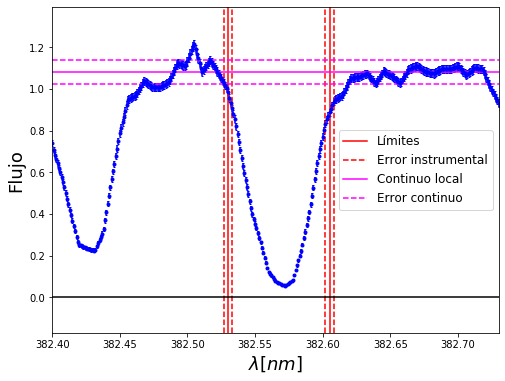

In [8]:
plt.figure(figsize = [8,6])

(_, caps, _) = plt.errorbar(c_s['waveobs'],c_s['flux'],c_s['err'], 0, color = 'blue', marker='.',ls = '',capsize=1)

for cap in caps:
    cap.set_markeredgewidth(1)
    

plt.axvline(382.53, color = 'red', label ='Límites')
plt.axvline(382.527, color = 'red', ls='--', label ='Error instrumental')
plt.axvline(382.533, color = 'red', ls='--')


plt.axvline(382.605, color = 'red')
plt.axvline(382.602, color = 'red', ls='--')
plt.axvline(382.608, color = 'red', ls='--')


#plt.axhline((c_s['flux'][7490:7551].mean() + c_s['flux'][7620:7680].mean())/2, color = 'magenta', label='Continuo local')
#plt.axhline((c_s['flux'][7490:7551].mean() + c_s['flux'][7620:7680].mean())/2 + (c_s['flux'][7620:7680].std() +c_s['flux'][7490:7551].std())/2, ls='--', color = 'magenta', label = 'Error de Continuo' )
#plt.axhline((c_s['flux'][7490:7551].mean() + c_s['flux'][7620:7680].mean())/2 - (c_s['flux'][7620:7680].std() +c_s['flux'][7490:7551].std())/2, ls='--', color = 'magenta')

plt.axhline(c_s['flux'][7490:7551].mean(), color = 'magenta', label='Continuo local')
plt.axhline(c_s['flux'][7490:7551].mean() + c_s['flux'][7490:7551].std(), ls ='--', color = 'magenta', label ='Error continuo' )
plt.axhline(c_s['flux'][7490:7551].mean() - c_s['flux'][7490:7551].std(), ls ='--',color = 'magenta' )

plt.axhline(0, color = 'black')

#plt.ylim(-2.5, 3)
plt.xlim(382.4,382.73)
#plt.grid()
#plt.legend(loc="best")
plt.ylabel("Flujo",fontsize=18)
plt.xlabel("$\lambda [nm]$",fontsize=18)
plt.legend(fontsize = 12)
plt.show()

# CURVAS DE CRECIMIENTO

## Ti ll

### Experimental

In [6]:
dataTi2_24oct  = dataTi2_24oct[~dataTi2_24oct.index.isin([0,1,8,13])]
dataTi2_24oct.index = list(range(len(dataTi2_24oct)))

In [168]:
dataTi2_24oct

,wave_peak,wave_base,wave_top,note,flux,loggf,lower_state_eV,upper_state_eV,EW,EWR,error_f,errEWR
0,390.063767,389.996654,390.106476,Ti 2,0.129236,-0.29,1.131,4.308,0.049013,-3.900827,0.007739,0.016607
1,391.351118,391.296207,391.399927,Ti 2,0.207386,-0.36,1.116,4.283,0.039436,-3.996678,0.006613,0.019102
2,393.205878,393.187575,393.218081,Ti 2,0.564217,-1.59,1.131,4.283,0.013836,-4.453613,0.006819,0.055756
3,430.008236,429.977730,430.044843,Ti 2,0.178665,-0.46,1.180,4.063,0.030766,-4.145413,0.006851,0.005036
4,439.507784,439.446772,439.550492,Ti 2,0.127288,-0.54,1.084,3.904,0.045070,-3.989078,0.007419,0.007147
5,444.388733,444.339923,444.437542,Ti 2,0.144923,-0.71,1.080,3.869,0.033833,-4.118417,0.006948,0.000791
6,450.129950,450.093342,450.172658,Ti 2,0.120890,-0.77,1.116,3.869,0.027581,-4.212729,0.126655,0.069920
7,454.955988,454.901078,455.010899,Ti 2,0.088935,-0.22,1.584,4.308,0.048464,-3.972547,0.120326,0.022999
8,456.359261,456.334856,456.420273,Ti 2,0.149394,-0.69,1.221,3.937,0.022006,-4.316760,0.078231,0.045424
9,457.207326,457.146314,457.250034,Ti 2,0.131799,-0.31,1.572,4.283,0.030167,-4.180579,0.006684,0.036572


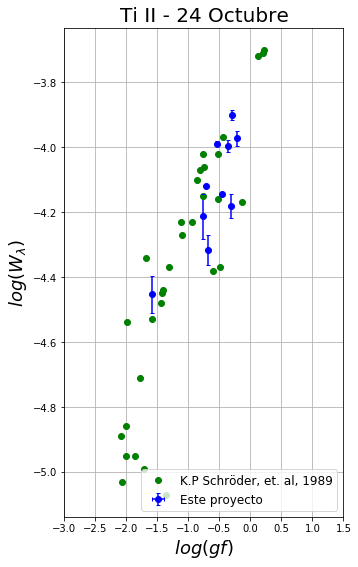

In [169]:
plt.figure(figsize = [5,9])

plt.plot(data_klausTi2['loggf'],data_klausTi2['ewr1'],marker='o', ls='', color = 'green', label = 'K.P Schröder, et. al, 1989')

(_, caps, _) = plt.errorbar(dataTi2_24oct['loggf'],dataTi2_24oct['EWR'],dataTi2_24oct['errEWR'], 0, color = 'blue', marker='o',ls = '',capsize=2,label = 'Este proyecto')

for cap in caps:
    cap.set_markeredgewidth(1)
    
plt.xlim(-3,1.5)
#plt.ylim(-5, -3.8)
plt.grid()
plt.legend(loc="best", fontsize=12)
plt.title('Ti II - 24 Octubre',fontsize=20)
plt.ylabel("$log(W_{\lambda})$",fontsize=18)
plt.xlabel("$log(gf)$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

In [183]:
dataTi2_25oct

,wave_peak,wave_base,wave_top,note,flux,loggf,lower_state_eV,upper_state_eV,EW,EWR,error_f,errEWR
0,376.116455,376.049342,376.183568,Ti 2,-0.036926,0.18,0.574,3.869,0.090394,-3.619181,0.007743,0.070765
1,388.233411,388.184602,388.239512,Ti 2,0.480805,-1.87,1.116,4.308,0.013732,-4.451358,0.006819,0.119903
2,391.357219,391.284005,391.381624,Ti 2,0.029227,-0.36,1.116,4.283,0.057148,-3.835570,0.006851,0.065061
3,401.247242,401.180129,401.259445,Ti 2,0.151288,-1.78,0.574,3.663,0.030756,-4.115475,0.006948,0.104205
4,416.158542,416.085328,416.164644,Ti 2,0.464828,-2.09,1.084,4.063,0.016613,-4.398821,0.126655,0.060110
5,417.354375,417.293363,417.366577,Ti 2,0.259662,-1.88,1.084,4.054,0.023891,-4.242262,0.078231,0.103253
6,428.794100,428.757493,428.830707,Ti 2,0.265140,-1.79,1.080,3.971,0.021182,-4.306286,0.006684,0.004657
7,430.014337,429.935022,430.057046,Ti 2,0.065231,-0.46,1.180,4.063,0.057738,-3.872022,0.006212,0.003547
8,431.295586,431.252878,431.338295,Ti 2,0.127632,-1.12,1.180,4.054,0.036908,-4.067654,0.006551,0.095530
9,431.503027,431.472521,431.545735,Ti 2,0.129131,-1.15,1.161,4.034,0.026454,-4.212489,0.007358,0.041607


In [7]:
dataTi2_25oct  = dataTi2_25oct[~dataTi2_25oct.index.isin([0,2,3,6,8,10,19])]
dataTi2_25oct.index = list(range(len(dataTi2_25oct)))

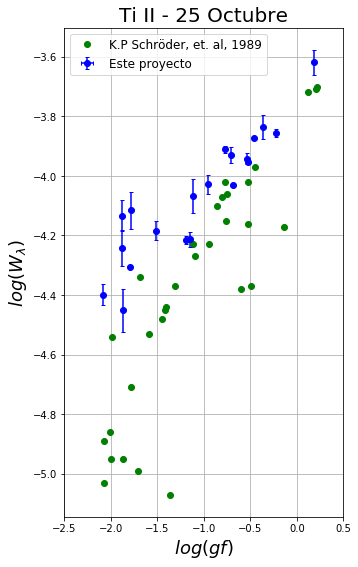

In [172]:
plt.figure(figsize = [5,9])
#plt.plot(-0.92,-4.334282,marker='o', ls='', color = 'red', label = 'prueba')
plt.plot(data_klausTi2['loggf'],data_klausTi2['ewr1'],marker='o', ls='', color = 'green', label = 'K.P Schröder, et. al, 1989')

(_, caps, _) = plt.errorbar(dataTi2_25oct['loggf'],dataTi2_25oct['EWR'],dataTi2_25oct['errEWR']*0.6, 0, color = 'blue', marker='o',ls = '',capsize=2,label = 'Este proyecto')

for cap in caps:
    cap.set_markeredgewidth(1)


    
plt.xlim(-2.5,0.5)
#plt.ylim(-5, -3)
plt.grid()
plt.legend(loc="best", fontsize=12)
plt.title('Ti II - 25 Octubre',fontsize=20)
plt.ylabel("$log(W_{\lambda})$",fontsize=18)
plt.xlabel("$log(gf)$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

### Teórica

In [8]:
def Growth_theoric(gf,_lambda,E_i,T_exc,Z):
    return (gf*_lambda*np.exp(-E_i/(8.617333262e-5*T_exc)))/Z


theo_Ti2_24oct = []
for i in range(0,len(dataTi2_24oct['loggf'])):
    theo_Ti2_24oct.append(Growth_theoric(10**(dataTi2_24oct['loggf'][i]), dataTi2_24oct['wave_peak'][i]*10, (-dataTi2_24oct['upper_state_eV'][i] + dataTi2_24oct['lower_state_eV'][i] ), 5000, 53.5))

def ajuste_teo_exp(x,N,a):
    return np.log10(x*N) + a
ajus, ajus1 = scipy.optimize.curve_fit(ajuste_teo_exp, np.array(theo_Ti2_24oct), dataTi2_24oct['loggf'])

theoric_newTi2_24oct = np.log10(np.array(theo_Ti2_24oct)*ajus[0]) + ajus[1]
print(ajus)
def ajuste(x,a,b):
    return a*x + b

popt1, pcov1 = scipy.optimize.curve_fit(ajuste, theoric_newTi2_24oct, dataTi2_24oct['EWR'])

xfit_Ti2_24 = np.linspace(min(theoric_newTi2_24oct), max(theoric_newTi2_24oct), 100)
yfit_Ti2_24 = ajuste(xfit_Ti2_24,*popt1)

[16.81436187 -6.04283824]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


In [9]:
theo_Ti2_24oct

[59574.017390866866,
 49705.940891276856,
 2840.1572614550446,
 22441.8726484905,
 16483.4336908583,
 10485.702436025396,
 8509.14641907135,
 28529.01379809763,
 9518.326469762584,
 22611.38323571647]

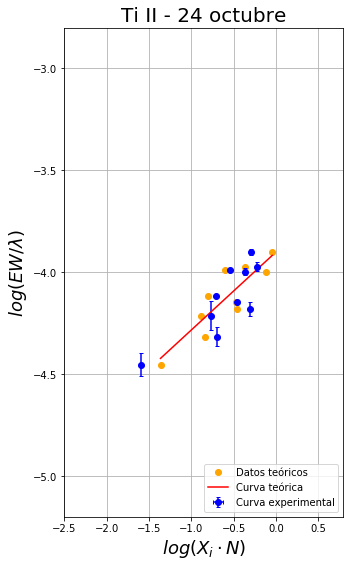

In [174]:
plt.figure(figsize = [5,9])

plt.plot(theoric_newTi2_24oct, dataTi2_24oct['EWR'],marker='o', color = 'orange', ls='', label = 'Datos teóricos')
plt.plot(xfit_Ti2_24,yfit_Ti2_24,marker='', ls='-', color = 'red', label = 'Curva teórica')
(_, caps, _) = plt.errorbar((dataTi2_24oct['loggf']),dataTi2_24oct['EWR'],dataTi2_24oct['errEWR'], 0, color = 'blue', marker='o',ls = '',capsize=2,label = 'Curva experimental')

for cap in caps:
    cap.set_markeredgewidth(1)

plt.xlim(-2.5,0.8)
plt.ylim(-5.2, -2.8)
plt.grid()
plt.legend(loc="lower right")
plt.title('Ti II - 24 octubre',fontsize=20)
plt.ylabel("$log(EW/\lambda)$",fontsize=18)
plt.xlabel("$log(X_i \cdot N)$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

In [10]:
theo_Ti2_25oct = []
for i in range(0,len(dataTi2_25oct['loggf'])):
    theo_Ti2_25oct.append(Growth_theoric(10**(dataTi2_25oct['loggf'][i]), dataTi2_25oct['wave_peak'][i]*10, (-dataTi2_25oct['upper_state_eV'][i] + dataTi2_25oct['lower_state_eV'][i] ), 5000, 53.5))

ajus2, ajus3 = scipy.optimize.curve_fit(ajuste_teo_exp, np.array(theo_Ti2_25oct), dataTi2_25oct['loggf'])

print(ajus2)
theoric_newTi2_25oct = np.log10(np.array(theo_Ti2_25oct)*ajus2[0]) + ajus2[1]
popt, pcov = scipy.optimize.curve_fit(ajuste, theoric_newTi2_25oct, dataTi2_25oct['EWR'])

xfit_Ti2_25 = np.linspace(min(theoric_newTi2_25oct), max(theoric_newTi2_25oct), 100)
yfit_Ti2_25 = ajuste(xfit_Ti2_25,*popt)

[ 2.45406928e-04 -1.21893508e+00]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


In [11]:
theo_Ti2_25oct

[222937.11456435896,
 1614.8549514110416,
 49706.71580977898,
 1616.714157967522,
 636.2164215894329,
 1013.396571314891,
 1066.3377048425598,
 22442.191065771378,
 4822.649871393882,
 4492.484731705195,
 829.9346377776396,
 6740.128844244897,
 16483.4336908583,
 3590.750674551343,
 10485.84639833302,
 1611.465817439697,
 8509.377089749405,
 14252.09220384241,
 28529.01379809763,
 9518.835481772358]

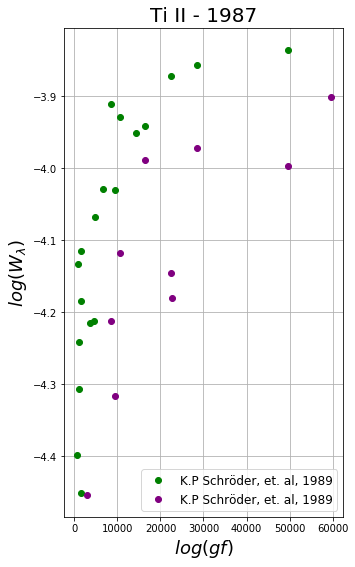

In [19]:

plt.figure(figsize = [5,9])

plt.plot(theo_Ti2_25oct[1:len(theo_Ti2_25oct)],dataTi2_25oct['EWR'][1:len(theo_Ti2_25oct)],marker='o', ls='', color = 'green', label = 'K.P Schröder, et. al, 1989')
plt.plot(theo_Ti2_24oct,dataTi2_24oct['EWR'],marker='o', ls='', color = 'purple', label = 'K.P Schröder, et. al, 1989')

#plt.xlim(-2.5,0.5)
#plt.ylim(-5, -3)
plt.grid()
plt.legend(loc="best", fontsize=12)
plt.title('Ti II - 1987',fontsize=20)
plt.ylabel("$log(W_{\lambda})$",fontsize=18)
plt.xlabel("$log(gf)$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

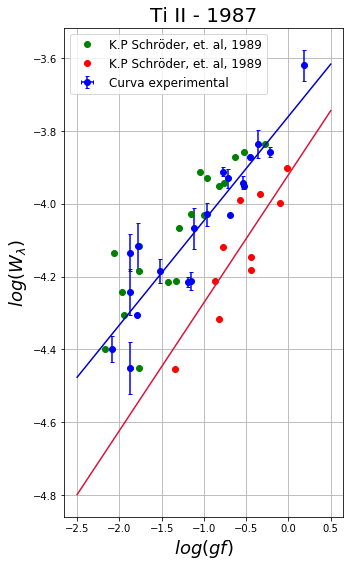

In [41]:
plt.figure(figsize = [5,9])

(_, caps, _) = plt.errorbar(dataTi2_25oct['loggf'],dataTi2_25oct['EWR'],dataTi2_25oct['errEWR']*0.6, 0, color = 'blue', marker='o',ls = '',capsize=2,label = 'Curva experimental')
plt.plot(np.log10(np.array(theo_Ti2_25oct[1:len(theo_Ti2_25oct)])*16.6290539) -6.2 ,dataTi2_25oct['EWR'][1:len(theo_Ti2_25oct)],marker='o', ls='', color = 'green', label = 'K.P Schröder, et. al, 1989')
#plt.plot(np.log10(np.array(theo_Ti2_24oct)) ,dataTi2_24oct['EWR'],marker='o', ls='', color = 'purple', label = 'K.P Schröder, et. al, 1989')
plt.plot(np.log10(np.array(theo_Ti2_24oct)*16) -6,dataTi2_24oct['EWR'],marker='o', ls='', color = 'red', label = 'K.P Schröder, et. al, 1989')

plt.plot(xfit,yfit1,marker='', ls='-', color = 'crimson')
plt.plot(xfit,yfit2,marker='', ls='-', color = 'mediumblue')

#plt.xlim(-2.5,0.5)
#plt.ylim(-5, -3)
plt.grid()
plt.legend(loc="best", fontsize=12)
plt.title('Ti II - 1987',fontsize=20)
plt.ylabel("$log(W_{\lambda})$",fontsize=18)
plt.xlabel("$log(gf)$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

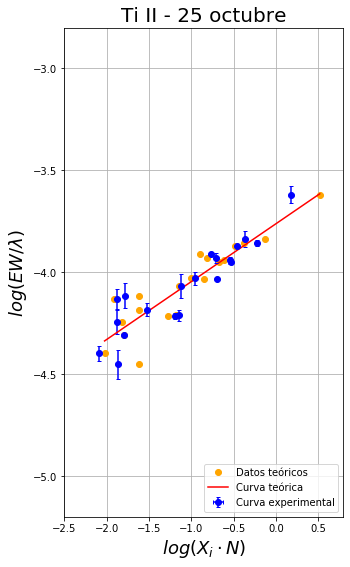

In [18]:
plt.figure(figsize = [5,9])

#plt.plot(np.log10(np.array(theo_Ti2_25oct)*0.16504051) -0.4141977, dataTi2_25oct['EWR'],marker='o', color = 'orange', ls='', label = 'Datos teóricos')
plt.plot(theoric_newTi2_25oct, dataTi2_25oct['EWR'],marker='o', color = 'orange', ls='', label = 'Datos teóricos')

plt.plot(xfit_Ti2_25,yfit_Ti2_25,marker='', ls='-', color = 'red', label = 'Curva teórica')
(_, caps, _) = plt.errorbar(dataTi2_25oct['loggf'],dataTi2_25oct['EWR'],dataTi2_25oct['errEWR']*0.6, 0, color = 'blue', marker='o',ls = '',capsize=2,label = 'Curva experimental')

#*2.32 + 2.79
for cap in caps:
    cap.set_markeredgewidth(1)

plt.xlim(-2.5,0.8)
plt.ylim(-5.2, -2.8)
plt.grid()
plt.legend(loc="lower right")
plt.title('Ti II - 25 octubre',fontsize=20)
plt.ylabel("$log(EW/\lambda)$",fontsize=18)
plt.xlabel("$log(X_i \cdot N)$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

In [28]:
uno, uno1 = scipy.optimize.curve_fit(lineal, dataTi2_24oct['loggf'],dataTi2_24oct['EWR'])
dos, dos2 = scipy.optimize.curve_fit(lineal, dataTi2_25oct['loggf'],dataTi2_25oct['EWR'])

xfit = np.linspace(-2.5, 0.5, 100)
yfit1 = lineal(xfit,*uno)
yfit2 = lineal(xfit,*dos)
print(uno[0],dos[0])

0.3516828673834931 0.28682294939098024


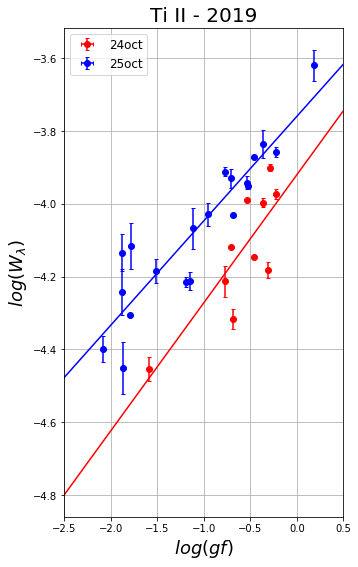

In [29]:
plt.figure(figsize = [5,9])

(_, caps, _) = plt.errorbar(dataTi2_24oct['loggf'],dataTi2_24oct['EWR'],dataTi2_24oct['errEWR']*0.6, 0, color = 'red', marker='o',ls = '',capsize=2,label = '24oct')
(_, caps, _) = plt.errorbar(dataTi2_25oct['loggf'],dataTi2_25oct['EWR'],dataTi2_25oct['errEWR']*0.6, 0, color = 'blue', marker='o',ls = '',capsize=2,label = '25oct')

plt.plot(xfit,yfit1,marker='', ls='-', color = 'red')
plt.plot(xfit,yfit2,marker='', ls='-', color = 'blue')

for cap in caps:
    cap.set_markeredgewidth(1)


    
plt.xlim(-2.5,0.5)
#plt.ylim(-5, -3)
plt.grid()
plt.legend(loc="best", fontsize=12)
plt.title('Ti II - 2019',fontsize=20)
plt.ylabel("$log(W_{\lambda})$",fontsize=18)
plt.xlabel("$log(gf)$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

In [188]:
data_klausTi2

,lambda,loggf,ewr1,ewr2
0,3685.19,0.20,-3.71,-3.65
1,3076.22,-0.60,-4.38,NaN
2,3741.63,-0.14,-4.17,-3.94
3,3757.68,-0.49,-4.37,NaN
4,3759.29,0.22,-3.70,-3.68
5,3761.32,0.12,-3.72,-3.70
6,3776.06,-1.37,-5.07,NaN
7,3786.33,-2.00,-4.95,NaN
8,3813.39,-1.99,-4.54,-4.02
9,3814.58,-1.69,-4.34,-3.95


In [189]:
tres, tres3 = scipy.optimize.curve_fit(lineal, data_klausTi2['loggf'],data_klausTi2['ewr1'])

xfit = np.linspace(-2.5, 0.5, 100)
yfit3 = lineal(xfit,*tres)

data_klausTi2  = data_klausTi2[~data_klausTi2.index.isin([1,3,6,7,13,15,16,19,24,25])]
data_klausTi2.index = list(range(len(data_klausTi2)))

cuatro, cuatro4 = scipy.optimize.curve_fit(lineal, data_klausTi2['loggf'],data_klausTi2['ewr2'])


yfit4 = lineal(xfit,*cuatro)
print(tres[0],cuatro[0])

0.500996407790496 0.1577391623842951


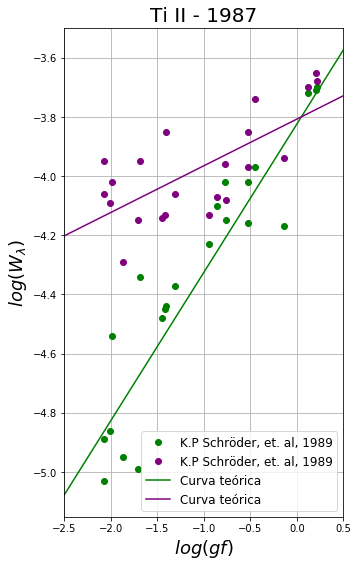

In [192]:

plt.figure(figsize = [5,9])




plt.plot(data_klausTi2['loggf'],data_klausTi2['ewr1'],marker='o', ls='', color = 'green', label = 'K.P Schröder, et. al, 1989')
plt.plot(data_klausTi2['loggf'],data_klausTi2['ewr2'],marker='o', ls='', color = 'purple', label = 'K.P Schröder, et. al, 1989')

plt.plot(xfit,yfit3,marker='', ls='-', color = 'green', label = 'Curva teórica')
plt.plot(xfit,yfit4,marker='', ls='-', color = 'purple', label = 'Curva teórica')

    
plt.xlim(-2.5,0.5)
#plt.ylim(-5, -3)
plt.grid()
plt.legend(loc="best", fontsize=12)
plt.title('Ti II - 1987',fontsize=20)
plt.ylabel("$log(W_{\lambda})$",fontsize=18)
plt.xlabel("$log(gf)$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

## Fe l

### Experimentales

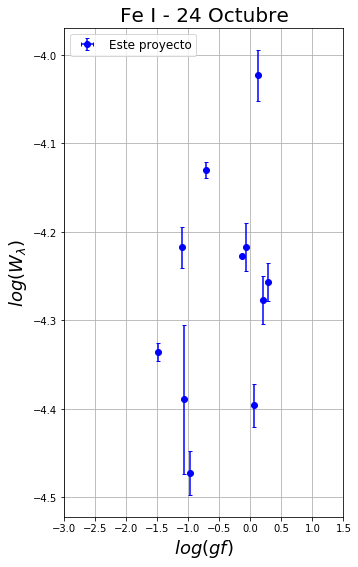

In [33]:
plt.figure(figsize = [5,9])

#plt.plot(data_klausFe1['loggf'],data_klausFe1['ewr2'],marker='o', ls='', color = 'green', label = 'K.P Schröder, et. al, 1989')

(_, caps, _) = plt.errorbar(dataFe1_24oct['loggf'],dataFe1_24oct['EWR'],dataFe1_24oct['errEWR']*0.6, 0, color = 'blue', marker='o',ls = '',capsize=2,label = 'Este proyecto')

for cap in caps:
    cap.set_markeredgewidth(1)

    
plt.xlim(-3,1.5)
#plt.ylim(-5, -3.8)
plt.grid()
plt.legend(loc="best", fontsize=12)
plt.title('Fe I - 24 Octubre',fontsize=20)
plt.ylabel("$log(W_{\lambda})$",fontsize=18)
plt.xlabel("$log(gf)$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

In [34]:
dataFe1_25oct

,wave_peak,wave_base,wave_top,note,flux,loggf,lower_state_eV,upper_state_eV,EW,EWR,error_f,errEWR
0,376.384907,376.317794,376.409312,Fe 1,0.094720,-0.238,0.990,4.283,0.041028,-3.962555,0.007090,0.083649
1,376.726573,376.659460,376.732674,Fe 1,0.114276,-0.389,1.011,4.301,0.026613,-4.150932,0.007743,0.234306
2,378.794876,378.733864,378.800977,Fe 1,0.322002,-0.859,1.011,4.283,0.016250,-4.367542,0.007739,0.195037
3,379.508714,379.447703,379.514816,Fe 1,0.178764,-0.761,0.990,4.256,0.022002,-4.236767,0.006613,0.230057
4,379.960202,379.911393,379.996809,Fe 1,0.145890,-0.846,0.958,4.220,0.035607,-4.028205,0.006819,0.218824
5,381.595320,381.522106,381.613624,Fe 1,0.174377,0.237,1.485,4.733,0.035848,-4.027143,0.006851,0.132191
6,382.052909,381.973594,382.083415,Fe 1,0.070941,0.119,0.859,4.103,0.061849,-3.790788,0.007419,0.024552
7,382.455588,382.388474,382.467790,Fe 1,0.205843,-1.362,0.000,3.241,0.036561,-4.019557,0.006948,0.116640
8,382.595915,382.516599,382.644724,Fe 1,0.081342,-0.037,0.915,4.154,0.049252,-3.890318,0.007209,0.085381
9,382.791153,382.717939,382.797254,Fe 1,0.205459,0.062,1.557,4.796,0.024568,-4.192589,0.126655,0.171857


In [38]:
dataFe1_25oct  = dataFe1_25oct[~dataFe1_25oct.index.isin([4,11])]
dataFe1_25oct.index = list(range(len(dataFe1_25oct)))

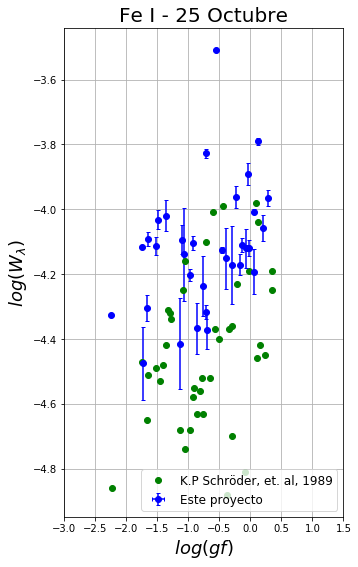

In [39]:
plt.figure(figsize = [5,9])

plt.plot(data_klausFe1['loggf'],data_klausFe1['ewr1'],marker='o', ls='', color = 'green', label = 'K.P Schröder, et. al, 1989')

(_, caps, _) = plt.errorbar(dataFe1_25oct['loggf'],dataFe1_25oct['EWR'],dataFe1_25oct['errEWR']*0.4, 0, color = 'blue', marker='o',ls = '',capsize=2,label = 'Este proyecto')

for cap in caps:
    cap.set_markeredgewidth(1)

plt.axv
plt.xlim(-3,1.5)
#plt.ylim(-5, -3.8)
plt.grid()
plt.legend(loc="best", fontsize=12)
plt.title('Fe I - 25 Octubre',fontsize=20)
plt.ylabel("$log(W_{\lambda})$",fontsize=18)
plt.xlabel("$log(gf)$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

### Teóricas

In [48]:
theo_Fe1_24oct = []
for i in range(0,len(dataFe1_24oct['loggf'])):
    theo_Fe1_24oct.append(Growth_theoric(10**(dataFe1_24oct['loggf'][i]), dataFe1_24oct['wave_peak'][i], (dataFe1_24oct['upper_state_eV'][i] - dataFe1_24oct['lower_state_eV'][i] ), 5000))

ajus4, ajus5 = scipy.optimize.curve_fit(ajuste_teo_exp, np.array(theo_Fe1_24oct), dataFe1_24oct['loggf'])

print(ajus4)
theoric_newFe1_24oct = np.log10(np.array(theo_Fe1_24oct)*ajus4[0]) + ajus4[1]
popt, pcov = scipy.optimize.curve_fit(ajuste, theoric_newFe1_24oct, dataFe1_24oct['EWR'])

xfit_Fe1_24 = np.linspace(min(theoric_newFe1_24oct), max(theoric_newFe1_24oct), 100)
yfit_Fe1_24 = ajuste(xfit_Fe1_24,*popt)

[0.05497172 0.0816054 ]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


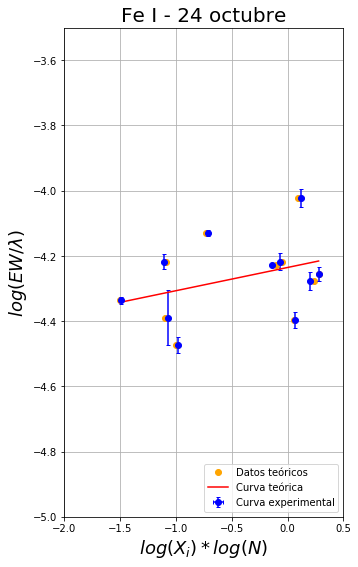

In [58]:
plt.figure(figsize = [5,9])

plt.plot(theoric_newFe1_24oct, dataFe1_24oct['EWR'],marker='o', color = 'orange', ls='', label = 'Datos teóricos')

plt.plot(xfit_Fe1_24,yfit_Fe1_24,marker='', ls='-', color = 'red', label = 'Curva teórica')
(_, caps, _) = plt.errorbar(dataFe1_24oct['loggf'],dataFe1_24oct['EWR'],dataFe1_24oct['errEWR']*0.6, 0, color = 'blue', marker='o',ls = '',capsize=2,label = 'Curva experimental')

#*2.32 + 2.79
for cap in caps:
    cap.set_markeredgewidth(1)

plt.xlim(-2,0.5)
plt.ylim(-5, -3.5)
plt.grid()
plt.legend(loc="lower right")
plt.title('Fe I - 24 octubre',fontsize=20)
plt.ylabel("$log(EW/\lambda)$",fontsize=18)
plt.xlabel("$log(X_i)*log(N)$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

In [51]:
theo_Fe1_25oct = []
for i in range(0,len(dataFe1_25oct['loggf'])):
    theo_Fe1_25oct.append(Growth_theoric(10**(dataFe1_25oct['loggf'][i]), dataFe1_25oct['wave_peak'][i], (dataFe1_25oct['upper_state_eV'][i] - dataFe1_25oct['lower_state_eV'][i] ), 5000))

ajus6, ajus7 = scipy.optimize.curve_fit(ajuste_teo_exp, np.array(theo_Fe1_25oct), dataFe1_25oct['loggf'])

print(ajus6)
theoric_newFe1_25oct = np.log10(np.array(theo_Fe1_25oct)*ajus6[0]) + ajus6[1]
popt, pcov = scipy.optimize.curve_fit(ajuste, theoric_newFe1_25oct, dataFe1_25oct['EWR'])

xfit_Fe1_25 = np.linspace(min(theoric_newFe1_25oct), max(theoric_newFe1_25oct), 100)
yfit_Fe1_25 = ajuste(xfit_Fe1_25,*popt)

[ 0.17756509 -0.41621617]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


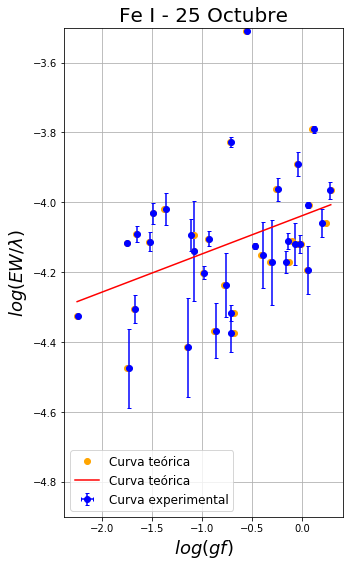

In [100]:
plt.figure(figsize = [5,9])

plt.plot(theoric_newFe1_25oct,dataFe1_25oct['EWR'],marker='o', ls='', color = 'orange', label = 'Curva teórica')
plt.plot(xfit_Fe1_25,yfit_Fe1_25,marker='', ls='-', color = 'red', label = 'Curva teórica')

(_, caps, _) = plt.errorbar(dataFe1_25oct['loggf'],dataFe1_25oct['EWR'],dataFe1_25oct['errEWR']*0.4, 0, color = 'blue', marker='o',ls = '',capsize=2,label = 'Curva experimental')

for cap in caps:
    cap.set_markeredgewidth(1)
    
#plt.xlim(-20,25)
plt.ylim(-4.9, -3.5)
plt.grid()
plt.legend(loc="lower right")
plt.title('Fe I - 25 Octubre',fontsize=20)
plt.ylabel("$log(EW/\lambda)$",fontsize=18)
plt.xlabel("$log(gf)$",fontsize=18)
#plt.xscale('log')

plt.legend(fontsize = 12)
plt.show()

## N vs h

In [61]:
h_1947 = np.array([9.4e5,11.6e5,17.6e5,24.3e5,25.8e5,27.6e5,41.5e5,48e5])*1.44
logN_1947_1 = [14.58,14.46,13.95,13.91,13.98,13.07,12.74,12.32]
logN_1947_2 = [14.11,13.75,13.34,13.18,12.99,12.34,12.01,11.62]

h_1987 = [6.13e6, 2.25e6]
logN_1987 = [16.15, 17]

h_2019 = [1.02e7,4.39e6]
logN_2019 = [16.81436187, 16.9362691]

In [62]:
logN_2019

[16.81436187, 16.9362691]

In [63]:
def lineal(x,a,b):
    return a*x + b
m, m_ = scipy.optimize.curve_fit(lineal, h_1947, logN_1947_1)
m1, m_1 = scipy.optimize.curve_fit(lineal, h_1947, logN_1947_2)
m2, m_2 = scipy.optimize.curve_fit(lineal, h_1987, logN_1987)
m3, m_3 = scipy.optimize.curve_fit(lineal, h_2019, logN_2019)


xfit = np.linspace(9e5, 1.05e7, 100)


yfit = lineal(xfit,*m)
yfit1 = lineal(xfit,*m1)
yfit2 = lineal(xfit,*m2)
yfit3 = lineal(xfit,*m3)


In [64]:
print(m[0], m1[0],m2[0],m3[0])

-4.032303023204445e-07 -4.2950718218047904e-07 -2.1907216494845445e-07 -2.098231153184172e-08


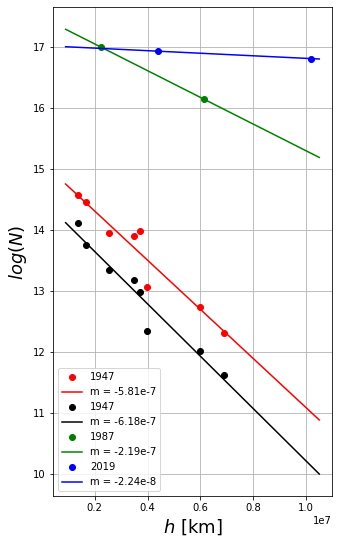

In [65]:
plt.figure(figsize = [5,9])

plt.plot(h_1947,logN_1947_1,marker='o', ls='', color = 'red', label = '1947')
plt.plot(xfit,yfit,marker='', ls='-', color = 'red', label = 'm = -5.81e-7')

plt.plot(h_1947,logN_1947_2,marker='o', ls='', color = 'black', label = '1947')
plt.plot(xfit,yfit1,marker='', ls='-', color = 'black', label = 'm = -6.18e-7')

plt.plot(h_1987,logN_1987,marker='o', ls='', color = 'green', label = '1987')
plt.plot(xfit,yfit2,marker='', ls='-', color = 'green', label = 'm = -2.19e-7')

plt.plot(h_2019,logN_2019,marker='o', ls='', color = 'blue', label = '2019')
plt.plot(xfit,yfit3,marker='', ls='-', color = 'blue', label = 'm = -2.24e-8')

plt.grid()
plt.legend(loc="lower right")
plt.ylabel("$log(N)$",fontsize=18)
plt.xlabel("$h$ [km]",fontsize=18)

plt.legend(fontsize = 10)
plt.show()


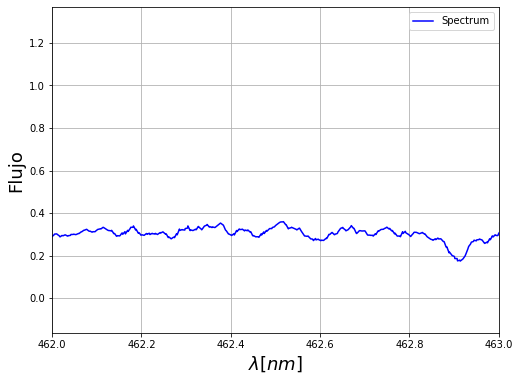

In [662]:
plt.figure(figsize = [8,6])

plt.plot(c_s['waveobs'],c_s['flux'],color = 'blue', marker='',ls = '-',label = 'Spectrum')


plt.axvline(458.31, color = 'red')
plt.axvline(458.416, color = 'red')

plt.xlim(462, 463)
plt.grid()
plt.legend(loc="best")
plt.ylabel("Flujo",fontsize=18)
plt.xlabel("$\lambda [nm]$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

In [3]:
b = c_s['waveobs']>376.075
a = c_s['waveobs']<376.210
c = a&b
errorA2 = np.sqrt(np.sum(c_s['err'][c]**2))

In [4]:
errorA2

0.20710838958897468

In [26]:
1.2*(0.05/1.2)*((0.03 + 0.03)/(0.1))

0.03

In [12]:
np.sqrt(np.sum(c_s['err'][c]**2))

0.20710838958897468